In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_regression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:f}'.format)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick


In [238]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb  # Exemplo com XGBoost, mas pode ser usado com outros modelos


# Model database

In [3]:
# Import final data base de inscritos presentes em todas as provas sem missing ~32 MM
df = pd.read_csv('df_basepronta2.csv', sep = ';')

print(df.shape)
#(1529177, 57)

(1529177, 85)


# Target Nota Geral

In [4]:
df.NU_MEDIA.describe()

count   1529177.000000
mean        481.328782
std          54.599088
min         316.625000
25%         441.175000
50%         475.000000
75%         516.100000
max         687.325000
Name: NU_MEDIA, dtype: float64

In [5]:
# target: variavel resposta dependente (desempenho em matematica) de acordo com um certo ponto de corte para cada ano (threshold):
threshold = .75

df_desemp = df.groupby('NU_ANO')['NU_MEDIA'].quantile(threshold).reset_index(name = 'desemp_geral')

In [6]:
df_desemp.shape

(9, 2)

In [7]:
df_desemp

,NU_ANO,desemp_geral
0,2015,503.375000
1,2016,507.875000
2,2017,516.975000
3,2018,533.875000
4,2019,510.125000
5,2020,518.050000
6,2021,506.725000
7,2022,521.800000
8,2023,524.800000


In [11]:
df['target_geral'] = np.where(df.NU_MEDIA < df_desemp.desemp_geral, 0, 1)

ValueError: Can only compare identically-labeled Series objects

In [6]:
df['target_geral'].value_counts(normalize=True) * 100

KeyError: 'target_geral'

## Ter internet em casa impacta o desempenho geral, para cada faixa de renda?

In [313]:
df.shape

(1529177, 90)

## Nota média geral e porcentagem de pessoas com acesso a internet
## em casa ao longo dos anos, em geral

In [12]:
def rend(df, y1min, y1max, y2min, y2max):
    
    var2 = 'NU_ANO'
    var3 = 'IeC'
    var4 = 'NU_MEDIA'
    tit  = 'Nota Média Geral e Acesso a Internet e ao Computador em casa'
 
    a = df.groupby([var2])[var4].mean().reset_index(name = 'mean_nota')
    b = df.groupby([var2])[var3].mean().reset_index(name = 'perc_internet')
    c = a.merge(b, on = [var2], how = 'left')

    fig, ax1 = plt.subplots(figsize = (10,5))

    ax2 = ax1.twinx()
    ax1.plot(c.NU_ANO, c.mean_nota, 'g-')
    ax2.plot(c.NU_ANO, c.perc_internet, 'b-')

    ax1.set_xlabel('Ano', fontsize = 14)

    ax1.set_ylabel('Nota', color='g', fontsize = 14)
    ax1.set_ylim(ymin=y1min, ymax=y1max)

    ax2.set_ylabel('% Acesso', color='b', fontsize = 14)
    ax2.set_ylim(ymin=y2min, ymax=y2max)

    fig.suptitle(tit, fontsize = 16);

In [17]:
def rend(df, y1min, y1max, y2min, y2max):
    
    var2 = 'NU_ANO'
    var3 = 'IeC'
    var4 = 'NU_MEDIA'
    tit  = 'Nota Média Geral e Acesso a Internet e ao Computador em casa'
 
    a = df.groupby([var2])[var4].mean().reset_index(name = 'mean_nota')
    b = df.groupby([var2])[var3].mean().reset_index(name = 'perc_internet')
    c = a.merge(b, on = [var2], how = 'left')

    fig, ax1 = plt.subplots(figsize = (10,5))

    ax2 = ax1.twinx()
    ax1.plot(c.NU_ANO, c.mean_nota, 'g-', label='Nota')
    ax2.plot(c.NU_ANO, c.perc_internet, 'b-', label='% Acesso')

    ax1.set_xlabel('Ano', fontsize = 14)
    ax1.set_ylabel('Nota', color='g', fontsize = 14)
    ax1.set_ylim(ymin=y1min, ymax=y1max)
    ax2.set_ylabel('% Acesso', color='b', fontsize = 14)
    ax2.set_ylim(ymin=y2min, ymax=y2max)

    # Adicionar rótulos para cada ponto
    for i in range(len(c)):
        ax1.annotate(f"{c.mean_nota[i]:.2f}", (c.NU_ANO[i], c.mean_nota[i]),
                     textcoords="offset points", xytext=(0,10), ha='center', color='g', fontsize=12)
        ax2.annotate(f"{c.perc_internet[i]:.2%}", (c.NU_ANO[i], c.perc_internet[i]),
                     textcoords="offset points", xytext=(0,-15), ha='center', color='b', fontsize=12)

    fig.suptitle(tit, fontsize = 16)
    plt.show()


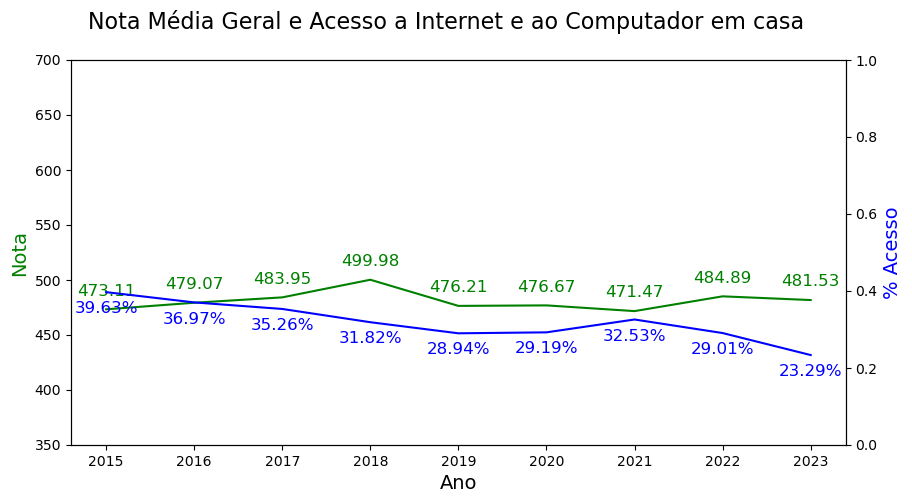

In [18]:
rend(df, y1min = 350, y1max = 700, y2min = 0.0, y2max = 1.0)

In [21]:
import matplotlib.pyplot as plt

def rend(df, y1min, y1max, y2min, y2max):
    
    var2 = 'NU_ANO'
    var3 = 'C'
    var5 = 'I'
    var4 = 'NU_MEDIA'
    tit = 'Nota Média Geral e Acesso domiciliar à Internet e ao Computador'
    
    # Calculando as médias para as variáveis
    a = df.groupby([var2])[var4].mean().reset_index(name='mean_nota')
    b = df.groupby([var2])[var5].mean().reset_index(name='perc_internet')
    d = df.groupby([var2])[var3].mean().reset_index(name='perc_computador')
    
    # Mesclando os dados
    c = a.merge(b, on=var2, how='left').merge(d, on=var2, how='left')

    # Criando a figura e os eixos
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plotando a nota média no eixo principal
    ax1.plot(c[var2], c['mean_nota'], 'g-', label='Nota Média')
    ax1.set_xlabel('Ano', fontsize=14)
    ax1.set_ylabel('Nota Média', color='g', fontsize=14)
    ax1.set_ylim(ymin=y1min, ymax=y1max)

    # Eixo secundário para os percentuais
    ax2 = ax1.twinx()
    ax2.plot(c[var2], c['perc_computador'], 'b-', label='% Computador')
    ax2.plot(c[var2], c['perc_internet'], 'r-', label='% Internet')
    ax2.set_ylabel('% Acessos', color='b', fontsize=14)
    ax2.set_ylim(ymin=y2min, ymax=y2max)

    # Adicionando título e legendas
    fig.suptitle(tit, fontsize=16)

    # Adicionar rótulos para cada ponto
    for i in range(len(c)):
        ax1.annotate(f"{c.mean_nota[i]:.2f}", (c.NU_ANO[i], c.mean_nota[i]),
                     textcoords="offset points", xytext=(0,10), ha='center', color='g', fontsize=12)
        ax2.annotate(f"{c.perc_internet[i]:.2%}", (c.NU_ANO[i], c.perc_internet[i]),
                     textcoords="offset points", xytext=(0,-15), ha='center', color='b', fontsize=12)
        ax2.annotate(f"{c.perc_computador[i]:.2%}", (c.NU_ANO[i], c.perc_computador[i]),
                     textcoords="offset points", xytext=(0,-15), ha='center', color='b', fontsize=12)
    
    plt.show()

    # Legenda combinada para as duas linhas do eixo secundário
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.show()


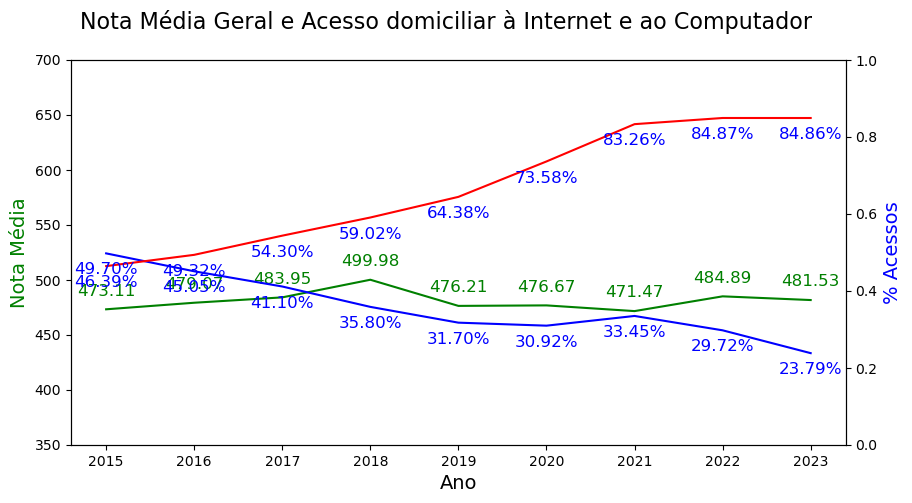

In [22]:
rend(df, y1min=350, y1max=700, y2min=0, y2max=1.0)

## Performance das classes de renda ao longo do tempo

### Nota média geral e porcentagem de pessoas com acesso a internet em casa ao longo dos anos

In [25]:
def rend_by_class(df, y1min, y1max, y2min, y2max):
    
    var2 = 'NU_ANO'
    var3 = 'IeC'
    var4 = 'NU_MEDIA'
    tit  = 'Nota Média Geral e Acesso a Internet e ao Computador em casa ' 
  

    a = df.groupby([var2])[var4].mean().reset_index(name = 'mean_nota')
    b = df.groupby([var2])[var3].mean().reset_index(name = 'perc_internet')
    c = a.merge(b, on = [var2], how = 'left')

    fig, ax1 = plt.subplots(figsize = (10,5))

    ax2 = ax1.twinx()
    ax1.plot(c.NU_ANO, c.mean_nota, 'g-')
    ax2.plot(c.NU_ANO, c.perc_internet, 'b-')

    ax1.set_xlabel('Ano', fontsize = 14)

    ax1.set_ylabel('Nota', color='g', fontsize = 14)
    ax1.set_ylim(ymin=y1min, ymax=y1max)

    ax2.set_ylabel('% Acesso', color='b', fontsize = 14)
    ax2.set_ylim(ymin=y2min, ymax=y2max)
    
        # Adicionar rótulos para cada ponto
    for i in range(len(c)):
        ax1.annotate(f"{c.mean_nota[i]:.2f}", (c.NU_ANO[i], c.mean_nota[i]),
                     textcoords="offset points", xytext=(0,10), ha='center', color='g', fontsize=12)
        ax2.annotate(f"{c.perc_internet[i]:.2%}", (c.NU_ANO[i], c.perc_internet[i]),
                     textcoords="offset points", xytext=(0,-15), ha='center', color='b', fontsize=12)

    fig.suptitle(tit, fontsize = 16);

    # print('\n')

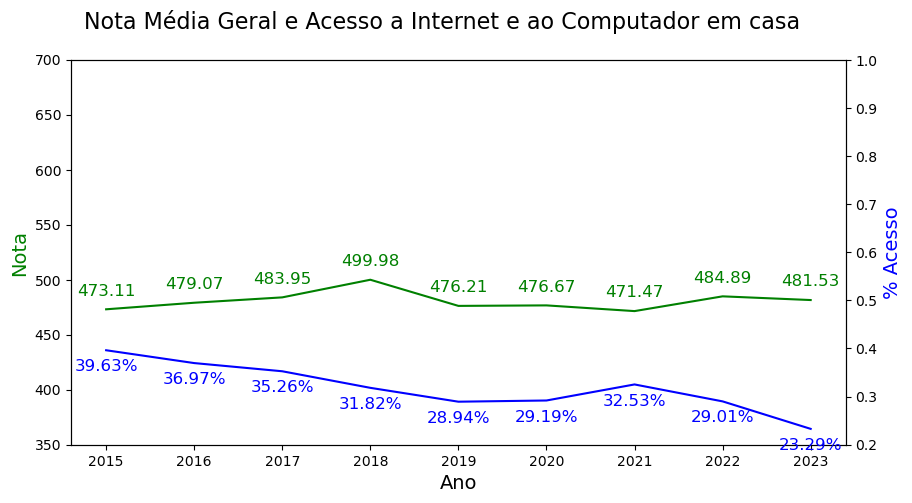

In [26]:
rend_by_class(df, y1min = 350, y1max = 700, y2min = 0.2, y2max = 1.0)

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def rend_by_class(df, y1min, y1max, y2min, y2max):
    
    var2 = 'NU_ANO'
    var3 = 'IeC'
    var4 = 'NU_MEDIA'
    tit = 'Nota Média Geral e Acesso a Internet e ao Computador em casa'
    
    # Criando as faixas de notas
    nfxs = 5  # Número de faixas que você quer criar
    bins = np.linspace(df[var4].min(), df[var4].max(), nfxs + 1)
    faixa_nomes = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins) - 1)]
    
    # Agrupando a variável NU_MEDIA em faixas
    df['faixa_nota'] = pd.cut(df[var4], bins=bins, labels=faixa_nomes, include_lowest=True)
    
    # Calculando a média das notas e o percentual de acesso à internet e ao computador
    a = df.groupby([var2])['NU_MEDIA'].mean().reset_index(name='mean_nota')
    b = df.groupby([var2])[var3].mean().reset_index(name='perc_internet')
    c = a.merge(b, on=[var2], how='left')

    # Criando o gráfico
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax2 = ax1.twinx()
    ax1.plot(c.NU_ANO, c.mean_nota, 'g-')
    ax2.plot(c.NU_ANO, c.perc_internet, 'b-')

    ax1.set_xlabel('Ano', fontsize=14)
    ax1.set_ylabel('Nota', color='g', fontsize=14)
    ax1.set_ylim(ymin=y1min, ymax=y1max)

    ax2.set_ylabel('% Acesso', color='b', fontsize=14)
    ax2.set_ylim(ymin=y2min, ymax=y2max)

    fig.suptitle(tit, fontsize=16)

    plt.show()

# Exemplo de chamada da função
# Substitua df pelo seu DataFrame e ajuste os valores de y1min, y1max, y2min, y2max conforme necessário
# rend_by_class(df, y1min=350, y1max=700, y2min=0, y2max=1.0)


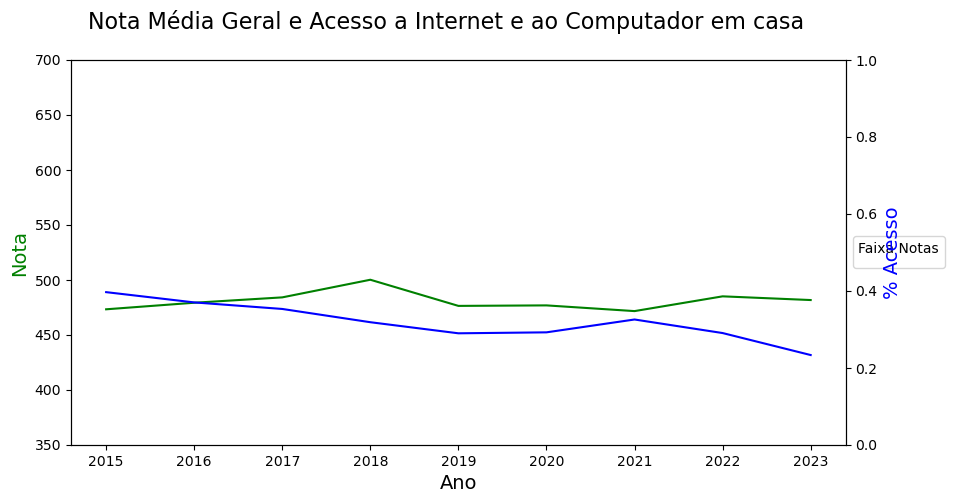

In [94]:
rend_by_class(df, y1min = 350, y1max = 700, y2min = 0, y2max = 1.0)

### Porcentagem de pessoas com acesso a internet em casa ao longo dos anos, por faixa de nota geral e classe (baixa, média e alta)

Dados agrupados e pivotados:
fx_var    0-10p   10-20p   20-30p   30-40p   40-50p   50-60p   60-70p  \
NU_ANO                                                                  
2015   0.269416 0.308634 0.328129 0.360512 0.375882 0.412615 0.436272   
2016   0.235588 0.262771 0.285041 0.311987 0.342040 0.373275 0.406251   
2017   0.205171 0.233680 0.265465 0.290678 0.316653 0.345196 0.376518   
2018   0.171879 0.190775 0.211616 0.233657 0.255071 0.271746 0.308537   
2019   0.168682 0.198493 0.218879 0.240078 0.271668 0.291346 0.322357   

fx_var   70-80p   80-90p  90-100p  
NU_ANO                             
2015   0.484505 0.528087 0.611582  
2016   0.447107 0.501942 0.596227  
2017   0.413847 0.472108 0.564671  
2018   0.345471 0.392925 0.498057  
2019   0.352400 0.407041 0.515791  
Gerando o gráfico...


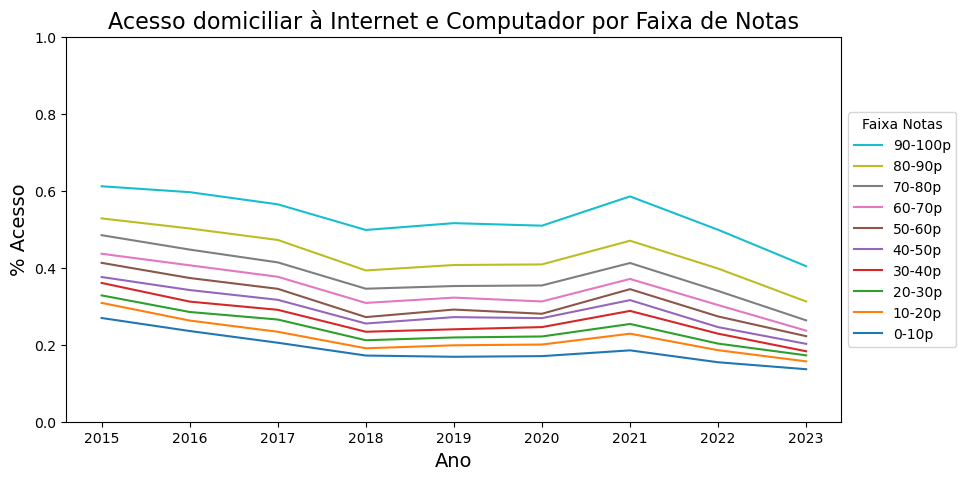

Gráfico exibido.


In [29]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def perc_by_class_fx_nota(df, fx_var, y1min=0, y1max=1):
    var1 = fx_var
    var2 = 'NU_ANO'
    var3 = 'IeC'
    tit = 'Acesso domiciliar à Internet e Computador por Faixa de Notas'
    
    # Criando faixas baseadas nos percentis
    nfxs = 10  # Número de faixas (percentis)
    percentiles = np.linspace(0, 100, nfxs + 1)
    bins = np.percentile(df['NU_MEDIA'], percentiles)
    faixa_nomes = [f'{int(percentiles[i])}-{int(percentiles[i+1])}p' for i in range(len(percentiles) - 1)]
    
    # Agrupando a variável NU_MEDIA em faixas de percentis
    df[var1] = pd.cut(df['NU_MEDIA'], bins=bins, labels=faixa_nomes, include_lowest=True)
    
    # Calculando a média do percentual de acesso à internet e computador em casa
    c = df.groupby([var2, var1])[var3].mean().reset_index(name='perc_IeC')
    
    print("Dados agrupados e pivotados:")
    pi = c.pivot(index=var2, columns=var1, values='perc_IeC')
    print(pi.head())  # Verifique se os dados estão corretos
    
    
        
   

    print("Gerando o gráfico...")
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Plotando as linhas na ordem normal
    lines = []
    for i, col in enumerate(pi.columns):
        line, = ax1.plot(pi.index, pi[col], label=col)
        lines.append(line)
    
    ax1.set_xlabel('Ano', fontsize=14)
    ax1.set_ylabel('% Acesso', fontsize=14)
    ax1.set_ylim(ymin=y1min, ymax=y1max)
    
    ax1.set_title(tit, fontsize=16)
    
    # Invertendo a ordem dos itens na legenda
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], title='Faixa Notas', loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    print("Gráfico exibido.")


# Exemplo de chamada da função
perc_by_class_fx_nota(df, fx_var='fx_var', y1min=0, y1max=1)


In [33]:
import pandas as pd
import numpy as np

def perc_by_class_fx_nota(df, fx_var, y1min=0, y1max=1):
    var1 = fx_var
    var2 = 'NU_ANO'
    var3 = 'IeC'
    
    # Criando faixas baseadas nos percentis
    nfxs = 10  # Número de faixas (percentis)
    percentiles = np.linspace(0, 100, nfxs + 1)
    bins = np.percentile(df['NU_MEDIA'], percentiles)
    faixa_nomes = [f'{int(percentiles[i])}-{int(percentiles[i+1])}p' for i in range(len(percentiles) - 1)]
    
    # Agrupando a variável NU_MEDIA em faixas de percentis
    df[var1] = pd.cut(df['NU_MEDIA'], bins=bins, labels=faixa_nomes, include_lowest=True)
    
    # Calculando a média do percentual de acesso e a contagem de observações por faixa e ano
    grouped = df.groupby([var2, var1]).agg(
        perc_IeC=('IeC', 'mean'),    # Média do percentual de acesso
        count_obs=('IeC', 'size')    # Contagem de observações
    ).reset_index()
    
    # Exibindo os dados agrupados e pivotados para verificar a estrutura
    print("Dados agrupados e com contagem de observações:")
    print(grouped.head())
    
    # Pivotando para facilitar a visualização (opcional, se você precisar apenas do gráfico, pode omitir esta etapa)
    pi = grouped.pivot(index=var2, columns=var1, values='perc_IeC')
    print("Tabela pivotada para visualização de média por faixa e ano:")
    print(pi.head())

    # Retornando o DataFrame com a média de acesso e contagem de observações por faixa e ano
    return grouped


# Exemplo de chamada da função
perc_by_class_fx_nota(df, fx_var='fx_var', y1min=0, y1max=1)

Dados agrupados e com contagem de observações:
   NU_ANO  fx_var  perc_IeC  count_obs
0    2015   0-10p  0.269416      22404
1    2015  10-20p  0.308634      21391
2    2015  20-30p  0.328129      21263
3    2015  30-40p  0.360512      21242
4    2015  40-50p  0.375882      21834
Tabela pivotada para visualização de média por faixa e ano:
fx_var    0-10p   10-20p   20-30p   30-40p   40-50p   50-60p   60-70p  \
NU_ANO                                                                  
2015   0.269416 0.308634 0.328129 0.360512 0.375882 0.412615 0.436272   
2016   0.235588 0.262771 0.285041 0.311987 0.342040 0.373275 0.406251   
2017   0.205171 0.233680 0.265465 0.290678 0.316653 0.345196 0.376518   
2018   0.171879 0.190775 0.211616 0.233657 0.255071 0.271746 0.308537   
2019   0.168682 0.198493 0.218879 0.240078 0.271668 0.291346 0.322357   

fx_var   70-80p   80-90p  90-100p  
NU_ANO                             
2015   0.484505 0.528087 0.611582  
2016   0.447107 0.501942 0.596227  
201

,NU_ANO,fx_var,perc_IeC,count_obs
0,2015,0-10p,0.269416,22404
1,2015,10-20p,0.308634,21391
2,2015,20-30p,0.328129,21263
3,2015,30-40p,0.360512,21242
4,2015,40-50p,0.375882,21834
5,2015,50-60p,0.412615,21434
6,2015,60-70p,0.436272,20203
7,2015,70-80p,0.484505,18425
8,2015,80-90p,0.528087,15185
9,2015,90-100p,0.611582,12036


## Um modelo geral

#### Verificar o feature importance de cada modelo

### Filtros

In [290]:
df_models = df

In [291]:
df_models.shape

(1529177, 87)

In [292]:

keep_y = ['target_geral']

keep_X_features = [
'FEMININO'
,'sóI'
,'sóC'
,'IeC'
,'Branca'
,'Parda'
,'Raca_outra'
,'CentroOeste'
,'Nordeste'
,'Norte'
,'Sudeste'
,'Sul'
,'escpartic_outra'
,'escpubl'
,'Mae_ESup_mais'
,'Mae_Ens_fundamental2'
,'Mae_Ens_medio3'
,'Mae_desc_nada0'
,'Mae_fund_incompl1'
,'Pai_ESup_mais'
,'Pai_Ens_fundamental2'
,'Pai_Ens_medio3'
,'Pai_desc_nada0'
,'Pai_fund_incompl1'
,'tamfam3peq'
,'tamfam5med'
,'tamfam6gde'
,'infra_basicacompleta'
,'infra_basicaincompleta'
,'renda_0e1'
,'renda_15'
]

# Análise Descritiva Geral

In [244]:
def quantidades(df, var, target):
    aux = df[[var, target]]
    a = aux.groupby([var, target]).size().reset_index(name = 'qtde')
    return a

In [245]:
df_models.shape

(1529177, 91)

In [205]:
df_models.describe().T

,count,mean,std,min,25%,50%,75%,max
NU_ANO,1529177.000000,2018.549254,2.569389,2015.000000,2016.000000,2018.000000,2021.000000,2023.000000
NU_IDADE,1529177.000000,18.383520,3.386246,10.000000,17.000000,18.000000,18.000000,83.000000
TP_ESTADO_CIVIL,1529177.000000,0.476714,0.534555,0.000000,0.000000,0.000000,1.000000,4.000000
TP_COR_RACA,1529177.000000,2.299621,0.982078,0.000000,1.000000,3.000000,3.000000,6.000000
TP_ST_CONCLUSAO,1529177.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
TP_ANO_CONCLUIU,1529177.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TP_ESCOLA,1529177.000000,2.035035,0.290189,1.000000,2.000000,2.000000,2.000000,4.000000
NU_NOTA_CN,1529177.000000,460.787984,59.856072,299.900000,415.100000,453.900000,501.300000,643.000000
NU_NOTA_CH,1529177.000000,501.400790,73.839578,293.500000,447.100000,503.400000,556.300000,727.400000
NU_NOTA_LC,1529177.000000,488.612997,65.177238,292.600000,444.700000,492.900000,535.600000,684.600000


In [293]:
target = 'target_geral'

# Modelagem geral

In [294]:
# Features
X = df_models[keep_X_features]

# Target
y = df_models[keep_y]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

print('Qtde treino.....:', X_train.shape[0])
print('Qtde teste......:', X_test.shape[0])

Qtde treino.....: 764588
Qtde teste......: 764589


## Testando os modelos: 

    - Regressão Logística
    - Árvore de Decisão
    - Random Forest
    - XGBoosting

In [295]:
# Regressão logística
#model_lr = LogisticRegression().fit(X_train, y_train.target_geral)

# Árvore de decisão
model_dt = DecisionTreeClassifier(min_samples_leaf=30).fit(X_train, y_train.target_geral)

# Random Forest
model_rf = RandomForestClassifier(min_samples_leaf=30).fit(X_train, y_train.target_geral)

# XGBoosting
model_xg = XGBClassifier().fit(X_train, y_train.target_geral)

In [296]:
#df_models['lr_pred'] = model_lr.predict_proba(df_models[keep_X_features])[:, 1]
df_models['dt_pred'] = model_dt.predict_proba(df_models[keep_X_features])[:, 1]
df_models['rf_pred'] = model_rf.predict_proba(df_models[keep_X_features])[:, 1]
df_models['xg_pred'] = model_xg.predict_proba(df_models[keep_X_features])[:, 1]

In [297]:
#y_train['lr_pred'] = model_lr.predict_proba(X_train)[:, 1]
#y_test['lr_pred'] = model_lr.predict_proba(X_test)[:, 1]

y_train['dt_pred'] = model_dt.predict_proba(X_train)[:, 1]
y_test['dt_pred'] = model_dt.predict_proba(X_test)[:, 1]

y_train['rf_pred'] = model_rf.predict_proba(X_train)[:, 1]
y_test['rf_pred'] = model_rf.predict_proba(X_test)[:, 1]

y_train['xg_pred'] = model_xg.predict_proba(X_train)[:, 1]
y_test['xg_pred'] = model_xg.predict_proba(X_test)[:, 1]

## AUC e ROC Curve

In [298]:
#AUC reg logistic pro treino e teste
#treino
#auc_lr_train = roc_auc_score(y_train.target_geral, y_train.lr_pred)
#fpr_lr_train, tpr_lr_train, thresholds_lr_train = roc_curve(y_train.target_geral, y_train.lr_pred)
#teste
#auc_lr_test = roc_auc_score(y_test.target_geral, y_test.lr_pred)
#fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test.target_geral, y_test.lr_pred)


#AUC Árvore de decisão pro treino e teste
#treino
auc_dt_train = roc_auc_score(y_train.target_geral, y_train.dt_pred)
fpr_dt_train, tpr_dt_train, thresholds_dt_train = roc_curve(y_train.target_geral, y_train.dt_pred)
#teste
auc_dt_test = roc_auc_score(y_test.target_geral, y_test.dt_pred)
fpr_dt_test, tpr_dt_test, thresholds_dt_test = roc_curve(y_test.target_geral, y_test.dt_pred)


#AUC Random Forest pro treino e teste
#treino
auc_rf_train = roc_auc_score(y_train.target_geral, y_train.rf_pred)
fpr_rf_train, tpr_rf_train, thresholds_rf_train = roc_curve(y_train.target_geral, y_train.rf_pred)
#teste
auc_rf_test = roc_auc_score(y_test.target_geral, y_test.rf_pred)
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(y_test.target_geral, y_test.rf_pred)


#AUC XGBoosting pro treino e teste
#treino
auc_xg_train = roc_auc_score(y_train.target_geral, y_train.xg_pred)
fpr_xg_train, tpr_xg_train, thresholds_xg_train = roc_curve(y_train.target_geral, y_train.xg_pred)
#teste
auc_xg_test = roc_auc_score(y_test.target_geral, y_test.xg_pred)
fpr_xg_test, tpr_xg_test, thresholds_xg_test = roc_curve(y_test.target_geral, y_test.xg_pred)

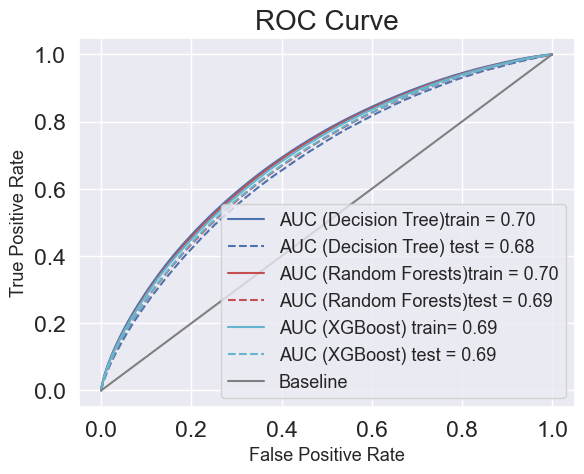

In [299]:
#Plotar todos no mesmo gráfico

#plt.figure(figsize=(16,10))
#plt.plot(fpr_lr_train, tpr_lr_train, linestyle = '-', color = 'g', label = f'AUC (Logistic Regression) train = {auc_lr_train:.2f}')
#plt.plot(fpr_lr_test, tpr_lr_test,  linestyle = '--', color = 'g', label=f'AUC (Logistic Regression) test = {auc_lr_test:.2f}')

plt.plot(fpr_dt_train, tpr_dt_train, linestyle = '-', color = 'b', label=f'AUC (Decision Tree)train = {auc_dt_train:.2f}')
plt.plot(fpr_dt_test, tpr_dt_test, linestyle = '--', color = 'b', label=f'AUC (Decision Tree) test = {auc_dt_test:.2f}')

plt.plot(fpr_rf_train, tpr_rf_train, linestyle = '-', color = 'r', label=f'AUC (Random Forests)train = {auc_rf_train:.2f}')
plt.plot(fpr_rf_test, tpr_rf_test, linestyle = '--', color = 'r', label=f'AUC (Random Forests)test = {auc_rf_test:.2f}')

plt.plot(fpr_xg_train, tpr_xg_train, linestyle = '-', color = 'c', label=f'AUC (XGBoost) train= {auc_xg_train:.2f}')
plt.plot(fpr_xg_test, tpr_xg_test, linestyle = '--', color = 'c', label=f'AUC (XGBoost) test = {auc_xg_test:.2f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.legend(prop={'size': 13});
plt.savefig('model_roc_curves.png', dpi=1200)

# Feature Importance

In [300]:
columns = ['model','feature','score']
rows = []

## Feature Importance: RL

In [301]:
#importance = model_lr.coef_[0]
#for i,v in enumerate(importance):
#    print(' %s ==> %.2f' % (keep_X_features[i], v))
#    row = ['lr', keep_X_features[i], v]
#    rows.append(row)

## Feature Importance: DT

In [302]:
importance = model_dt.feature_importances_
for i,v in enumerate(importance):
    print(' %s ==> %.2f' % (keep_X_features[i], v))
    row = ['dt', keep_X_features[i], v]
    rows.append(row)

 FEMININO ==> 0.07
 sóI ==> 0.01
 sóC ==> 0.01
 IeC ==> 0.31
 Branca ==> 0.05
 Parda ==> 0.01
 Raca_outra ==> 0.01
 CentroOeste ==> 0.01
 Nordeste ==> 0.01
 Norte ==> 0.02
 Sudeste ==> 0.03
 Sul ==> 0.01
 escpartic_outra ==> 0.11
 escpubl ==> 0.00
 Mae_ESup_mais ==> 0.02
 Mae_Ens_fundamental2 ==> 0.01
 Mae_Ens_medio3 ==> 0.04
 Mae_desc_nada0 ==> 0.02
 Mae_fund_incompl1 ==> 0.01
 Pai_ESup_mais ==> 0.02
 Pai_Ens_fundamental2 ==> 0.01
 Pai_Ens_medio3 ==> 0.02
 Pai_desc_nada0 ==> 0.01
 Pai_fund_incompl1 ==> 0.01
 tamfam3peq ==> 0.02
 tamfam5med ==> 0.01
 tamfam6gde ==> 0.01
 infra_basicacompleta ==> 0.01
 infra_basicaincompleta ==> 0.01
 renda_0e1 ==> 0.01
 renda_15 ==> 0.07


## Feature Importance: RF

In [303]:
importance = model_rf.feature_importances_
for i,v in enumerate(importance):
    print(' %s ==> %.2f' % (keep_X_features[i], v))
    row = ['rf', keep_X_features[i], v]
    rows.append(row)

 FEMININO ==> 0.08
 sóI ==> 0.02
 sóC ==> 0.01
 IeC ==> 0.19
 Branca ==> 0.06
 Parda ==> 0.01
 Raca_outra ==> 0.01
 CentroOeste ==> 0.01
 Nordeste ==> 0.01
 Norte ==> 0.02
 Sudeste ==> 0.04
 Sul ==> 0.01
 escpartic_outra ==> 0.07
 escpubl ==> 0.06
 Mae_ESup_mais ==> 0.02
 Mae_Ens_fundamental2 ==> 0.01
 Mae_Ens_medio3 ==> 0.04
 Mae_desc_nada0 ==> 0.02
 Mae_fund_incompl1 ==> 0.02
 Pai_ESup_mais ==> 0.02
 Pai_Ens_fundamental2 ==> 0.01
 Pai_Ens_medio3 ==> 0.03
 Pai_desc_nada0 ==> 0.01
 Pai_fund_incompl1 ==> 0.02
 tamfam3peq ==> 0.02
 tamfam5med ==> 0.01
 tamfam6gde ==> 0.02
 infra_basicacompleta ==> 0.01
 infra_basicaincompleta ==> 0.01
 renda_0e1 ==> 0.05
 renda_15 ==> 0.07


## Feature Importance: XG

In [304]:
importance = model_xg.feature_importances_
for i,v in enumerate(importance):
    print(' %s ==> %.2f' % (keep_X_features[i], v))
    row = ['xg', keep_X_features[i], v]
    rows.append(row)

 FEMININO ==> 0.06
 sóI ==> 0.02
 sóC ==> 0.02
 IeC ==> 0.30
 Branca ==> 0.06
 Parda ==> 0.00
 Raca_outra ==> 0.00
 CentroOeste ==> 0.01
 Nordeste ==> 0.01
 Norte ==> 0.03
 Sudeste ==> 0.05
 Sul ==> 0.01
 escpartic_outra ==> 0.08
 escpubl ==> 0.00
 Mae_ESup_mais ==> 0.02
 Mae_Ens_fundamental2 ==> 0.01
 Mae_Ens_medio3 ==> 0.05
 Mae_desc_nada0 ==> 0.04
 Mae_fund_incompl1 ==> 0.03
 Pai_ESup_mais ==> 0.03
 Pai_Ens_fundamental2 ==> 0.01
 Pai_Ens_medio3 ==> 0.04
 Pai_desc_nada0 ==> 0.01
 Pai_fund_incompl1 ==> 0.01
 tamfam3peq ==> 0.03
 tamfam5med ==> 0.01
 tamfam6gde ==> 0.02
 infra_basicacompleta ==> 0.00
 infra_basicaincompleta ==> 0.00
 renda_0e1 ==> 0.06
 renda_15 ==> 0.00


## All Feature Importances

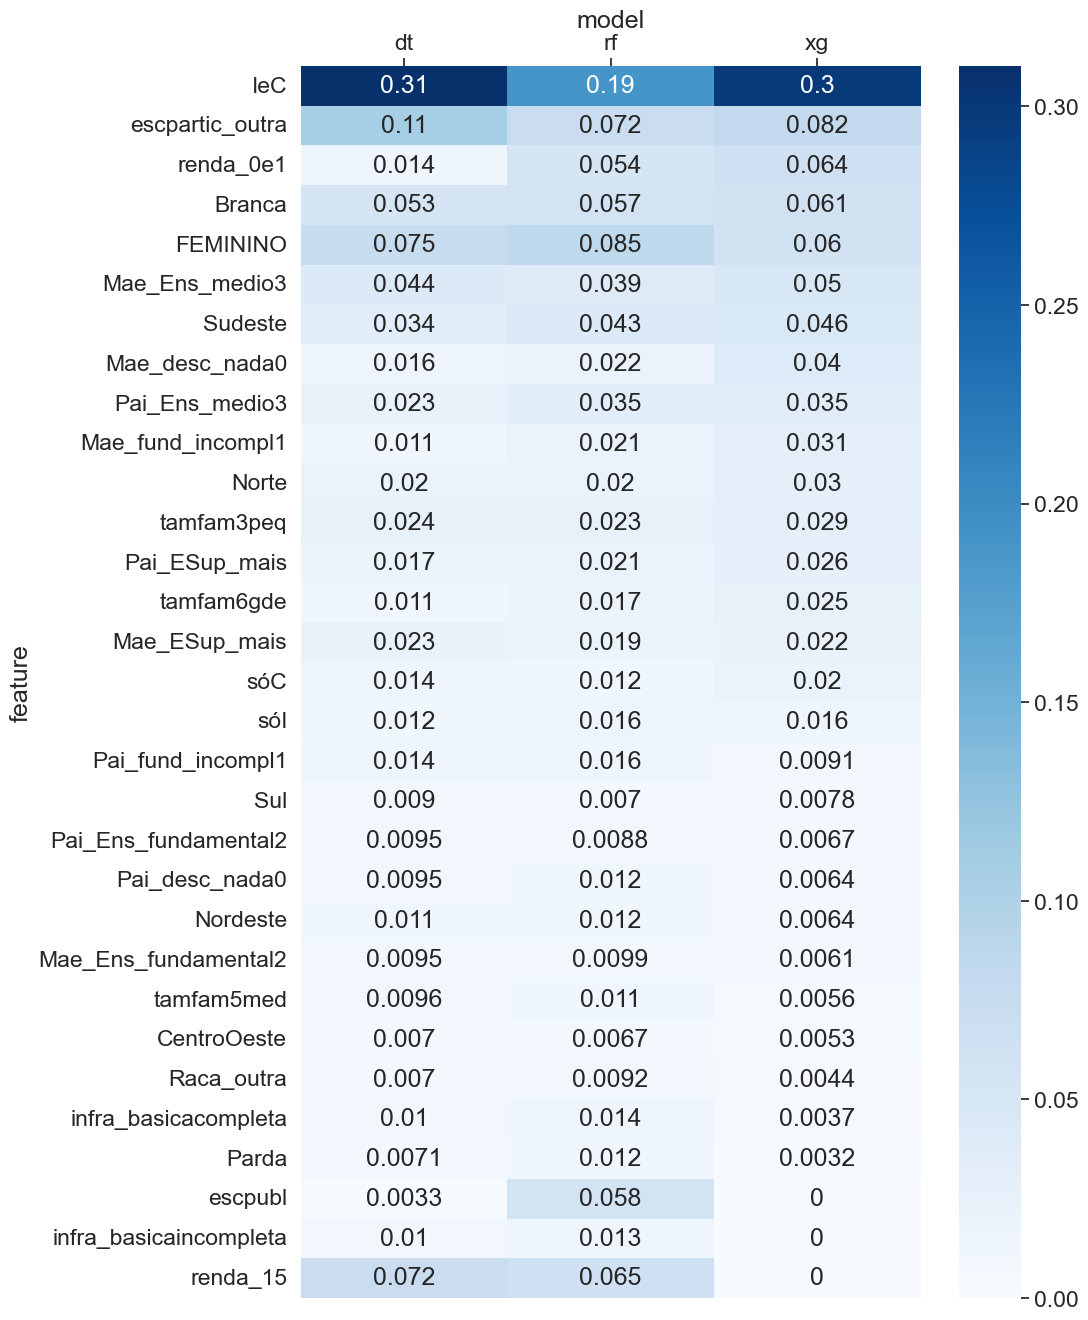

In [305]:
df_feat_impor = pd.DataFrame(rows, columns=columns)

# importância ordenada pelo melhor modelo na validação (xg)
imp = df_feat_impor.pivot(index = 'feature', columns = 'model', values = 'score').sort_values(by=['xg'],ascending=False)

fig, ax = plt.subplots(figsize=(10,16))
sns.heatmap(imp, cmap = 'Blues', annot=True, ax = ax)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()

In [317]:
imp.to_excel("general_models_feature_importance_classificacao_final2708.xlsx")

## medida de robustez dos modelos

### Permutation Feature Importance

In [273]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

# Calculando a Importância por Permutação para o modelo de Decision Tree
perm_importance_dt = permutation_importance(model_dt, X_test, y_test.target_geral, n_repeats=30, random_state=42, n_jobs=-1)

# Calculando a Importância por Permutação para o modelo Random Forest
perm_importance_rf = permutation_importance(model_rf, X_test, y_test.target_geral, n_repeats=30, random_state=42, n_jobs=-1)

# Calculando a Importância por Permutação para o modelo XGBoost
perm_importance_xg = permutation_importance(model_xg, X_test, y_test.target_geral, n_repeats=30, random_state=42, n_jobs=-1)

# Exibindo as importâncias para o modelo de Decision Tree
feature_names = keep_X_features
perm_importances_dt_df = pd.DataFrame({"Feature": feature_names, "Importance": perm_importance_dt.importances_mean})
perm_importances_dt_df.sort_values(by="Importance", ascending=False, inplace=True)
print("Decision Tree Feature Importances:\n", perm_importances_dt_df)

# Exibindo as importâncias para o modelo de Random Forest
perm_importances_rf_df = pd.DataFrame({"Feature": feature_names, "Importance": perm_importance_rf.importances_mean})
perm_importances_rf_df.sort_values(by="Importance", ascending=False, inplace=True)
print("Random Forest Feature Importances:\n", perm_importances_rf_df)

# Exibindo as importâncias para o modelo de XGBoost
perm_importances_xg_df = pd.DataFrame({"Feature": feature_names, "Importance": perm_importance_xg.importances_mean})
perm_importances_xg_df.sort_values(by="Importance", ascending=False, inplace=True)
print("XGBoost Feature Importances:\n", perm_importances_xg_df)


Decision Tree Feature Importances:
                    Feature  Importance
12         escpartic_outra    0.004724
3                      IeC    0.002468
0                 FEMININO    0.002296
4                   Branca    0.001393
13                 escpubl    0.001215
24              tamfam3peq    0.001127
21          Pai_Ens_medio3    0.000925
23       Pai_fund_incompl1    0.000773
19           Pai_ESup_mais    0.000762
18       Mae_fund_incompl1    0.000747
10                 Sudeste    0.000556
9                    Norte    0.000527
30                renda_15    0.000517
17          Mae_desc_nada0    0.000512
16          Mae_Ens_medio3    0.000481
8                 Nordeste    0.000399
14           Mae_ESup_mais    0.000221
7              CentroOeste    0.000204
15    Mae_Ens_fundamental2    0.000195
29               renda_0e1    0.000179
25              tamfam5med    0.000175
27    infra_basicacompleta    0.000095
6               Raca_outra    0.000079
22          Pai_desc_nada0  

###  Cross-Validation (Validação Cruzada)

In [274]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# Configurando a Validação Cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Função para calcular a importância das variáveis em cada iteração
def compute_feature_importance_cv(model, X, y, cv):
    importances = np.zeros(X.shape[1])
    
    for train_idx, test_idx in cv.split(X, y):
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        model.fit(X_train_cv, y_train_cv)
        fold_importances = model.feature_importances_
        importances += fold_importances
        
    importances /= cv.get_n_splits()
    return importances

# Aplicando a validação cruzada para cada modelo
cv_importances_dt = compute_feature_importance_cv(model_dt, X_train.values, y_train.target_geral.values, cv)
cv_importances_rf = compute_feature_importance_cv(model_rf, X_train.values, y_train.target_geral.values, cv)
cv_importances_xg = compute_feature_importance_cv(model_xg, X_train.values, y_train.target_geral.values, cv)

# Exibindo as importâncias médias para Decision Tree
feature_importances_dt_df = pd.DataFrame({"Feature": feature_names, "Importance": cv_importances_dt})
feature_importances_dt_df.sort_values(by="Importance", ascending=False, inplace=True)
print("Decision Tree Feature Importances with Cross-Validation:\n", feature_importances_dt_df)

# Exibindo as importâncias médias para Random Forest
feature_importances_rf_df = pd.DataFrame({"Feature": feature_names, "Importance": cv_importances_rf})
feature_importances_rf_df.sort_values(by="Importance", ascending=False, inplace=True)
print("Random Forest Feature Importances with Cross-Validation:\n", feature_importances_rf_df)

# Exibindo as importâncias médias para XGBoost
feature_importances_xg_df = pd.DataFrame({"Feature": feature_names, "Importance": cv_importances_xg})
feature_importances_xg_df.sort_values(by="Importance", ascending=False, inplace=True)
print("XGBoost Feature Importances with Cross-Validation:\n", feature_importances_xg_df)


Decision Tree Feature Importances with Cross-Validation:
                    Feature  Importance
3                      IeC    0.305737
0                 FEMININO    0.073373
13                 escpubl    0.058093
4                   Branca    0.053569
12         escpartic_outra    0.052829
29               renda_0e1    0.047074
16          Mae_Ens_medio3    0.041897
30                renda_15    0.037373
10                 Sudeste    0.033383
24              tamfam3peq    0.024736
21          Pai_Ens_medio3    0.023505
14           Mae_ESup_mais    0.021347
9                    Norte    0.019765
19           Pai_ESup_mais    0.017367
17          Mae_desc_nada0    0.016235
23       Pai_fund_incompl1    0.015773
2                      sóC    0.013678
1                      sóI    0.013557
26              tamfam6gde    0.012407
18       Mae_fund_incompl1    0.012227
8                 Nordeste    0.012093
28  infra_basicaincompleta    0.010766
27    infra_basicacompleta    0.010733
15    

# SHAP Values

In [ ]:
# Train Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

100%|===================| 764567/764589 [64:53<00:00]        

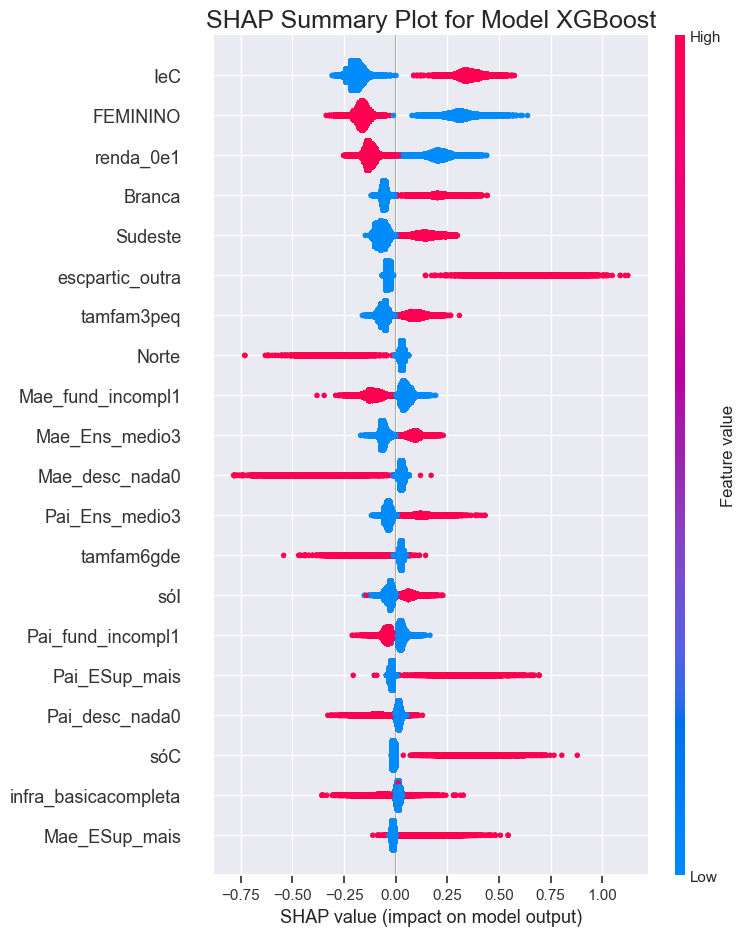

In [259]:
explainer = shap.Explainer(model_xg, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot for Model XGBoost')
plt.show()

### tirar uma amostra aleatoria de cada ano para rodar o SHAP por ano

In [280]:
# Exemplo: Filtrando para o ano de 2020
ano_selecionado = 2023

# Filtrando os dados por ano
X_test_ano = X_test[X_test['NU_ANO'] == ano_selecionado]


KeyError: 'NU_ANO'

In [ ]:
# Definir uma semente para garantir que a amostra possa ser reproduzida
seed = 42

# Extrair uma amostra de 30% de cada ano com uma semente aleatória
df = df.groupby('NU_ANO').apply(lambda x: x.sample(frac=0.3, random_state=seed)).reset_index(drop=True)

In [279]:
model_xg.shape

AttributeError: 'XGBClassifier' object has no attribute 'shape'

# Questão #2

### A importância da variável "acesso a internet", para predizer a performance geral do aluno, aumentou ao longo dos anos?

# Um modelo por ano

#### Controlado por faixa de renda (classe = baixa renda) e ocupação da mãe (grupos 1, 2 e 3) e ocupação do pai (grupos 1, 2 e 3)

#### Verificar o feature importance de cada ano dos modelos XGBoost

## Datasets

In [307]:
anos = df_models.NU_ANO.unique()

In [308]:
### Para cada ano, temos um conjunto de dados:

df_models_ano = {}
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}


for i, ano in enumerate(anos):
    
    # df
    df_models_ano[i] = df_models[df_models['NU_ANO'] == ano]
    
    # Features
    X[i] = df_models[df_models['NU_ANO'] == ano][keep_X_features]
    print('Shape X[',ano,']..:', X[i].shape)
    
    # Target
    y[i] = df_models[df_models['NU_ANO'] == ano][keep_y]

    # Train Test Split
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size = 0.5, random_state = 42)

    print('Qtde treino......:', X_train[i].shape)
    print('Qtde teste.......:', X_test[i].shape)

Shape X[ 2015 ]..: (195417, 31)
Qtde treino......: (97708, 31)
Qtde teste.......: (97709, 31)
Shape X[ 2016 ]..: (219986, 31)
Qtde treino......: (109993, 31)
Qtde teste.......: (109993, 31)
Shape X[ 2017 ]..: (209467, 31)
Qtde treino......: (104733, 31)
Qtde teste.......: (104734, 31)
Shape X[ 2018 ]..: (196173, 31)
Qtde treino......: (98086, 31)
Qtde teste.......: (98087, 31)
Shape X[ 2019 ]..: (189130, 31)
Qtde treino......: (94565, 31)
Qtde teste.......: (94565, 31)
Shape X[ 2020 ]..: (115977, 31)
Qtde treino......: (57988, 31)
Qtde teste.......: (57989, 31)
Shape X[ 2021 ]..: (112647, 31)
Qtde treino......: (56323, 31)
Qtde teste.......: (56324, 31)
Shape X[ 2022 ]..: (135328, 31)
Qtde treino......: (67664, 31)
Qtde teste.......: (67664, 31)
Shape X[ 2023 ]..: (155052, 31)
Qtde treino......: (77526, 31)
Qtde teste.......: (77526, 31)


## XGBoost Models

In [309]:
# XGBoosting
model_xg = {}
auc_xg_train = {}
fpr_xg_train = {}
tpr_xg_train = {}
thresholds_xg_train = {}

auc_xg_test = {}
fpr_xg_test = {}
tpr_xg_test = {}
thresholds_xg_test = {}

columns = ['model','ano','feature','score']
rows_anos = []

for i, ano in enumerate(anos):
    
    print('Ano', ano, ':')
    # Fit model
    print('    Fit...')
    model_xg[i] = XGBClassifier().fit(X_train[i], y_train[i].target_geral, eval_metric = 'logloss')
    
    # Apply model
    print('    Apply...')
    df_models_ano[i]['xg_pred'] = model_xg[i].predict_proba(df_models_ano[i][keep_X_features])[:, 1]
    
    # Compare
    print('    Compare...')
    y_train[i]['xg_pred'] = model_xg[i].predict_proba(X_train[i])[:, 1]
    y_test[i]['xg_pred'] = model_xg[i].predict_proba(X_test[i])[:, 1]
        
    # AUC pro treino e teste
    print('    AUCs:')
    # treino
    auc_xg_train[i] = roc_auc_score(y_train[i].target_geral, y_train[i].xg_pred)
    fpr_xg_train[i], tpr_xg_train[i], thresholds_xg_train[i] = roc_curve(y_train[i].target_geral, y_train[i].xg_pred)
    print('        Treino:', auc_xg_train[i])
    
    # teste
    auc_xg_test[i] = roc_auc_score(y_test[i].target_geral, y_test[i].xg_pred)
    fpr_xg_test[i], tpr_xg_test[i], thresholds_xg_test[i] = roc_curve(y_test[i].target_geral, y_test[i].xg_pred)
    print('        Teste:', auc_xg_test[i])
    
    # Feature importance
    print('    Feature importance...')
    importance = model_xg[i].feature_importances_
    for j, v in enumerate(importance):
        row = ['xg', ano, keep_X_features[j], v]
        rows_anos.append(row)

Ano 2015 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7166232217059885
        Teste: 0.6709180274181115
    Feature importance...
Ano 2016 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7204279267840482
        Teste: 0.6737317741656413
    Feature importance...
Ano 2017 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7228129595512319
        Teste: 0.6771127644260657
    Feature importance...
Ano 2018 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7209559172593649
        Teste: 0.667785724026765
    Feature importance...
Ano 2019 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.725332503782158
        Teste: 0.6767257097777771
    Feature importance...
Ano 2020 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7534032065043131
        Teste: 0.6875219690294108
    Feature importance...
Ano 2021 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Trei

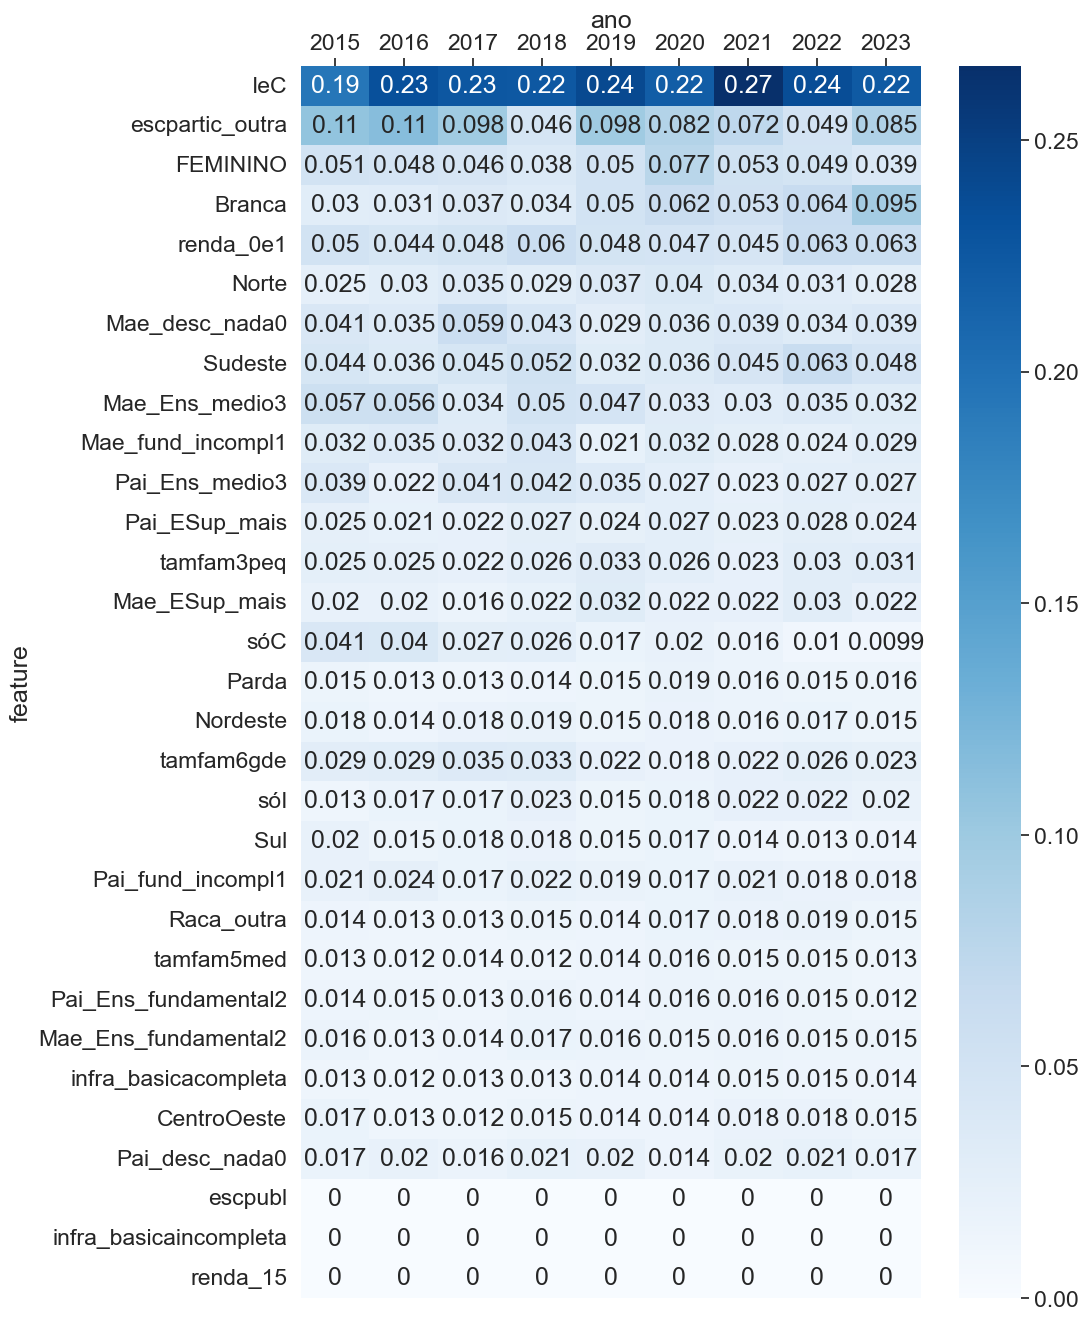

In [312]:
df_feat_impor_anos = pd.DataFrame(rows_anos, columns=columns)

# importância ordenada pelo melhor modelo na validação (xg)
imp_anos = df_feat_impor_anos.pivot(index = 'feature', columns = 'ano', values = 'score').sort_values(by=[2020], ascending = False)

fig, ax = plt.subplots(figsize=(10,16))
sns.heatmap(imp_anos, cmap = 'Blues', annot=True, ax = ax)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()

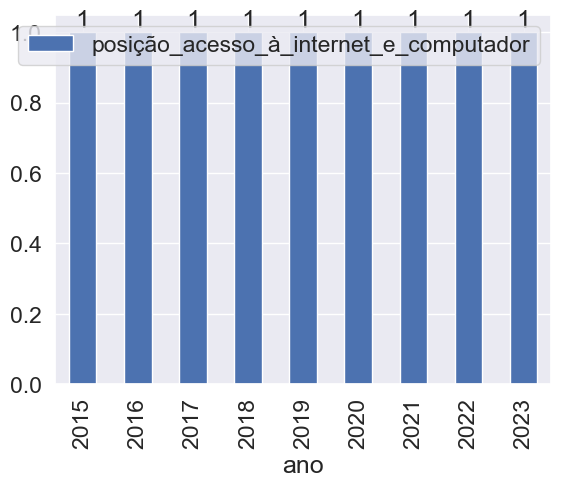

In [230]:
columns = ['ano', 'posição_acesso_à_internet_e_computador']
rows = []

for i, ano in enumerate(anos):
    
    imp_anos = df_feat_impor_anos.pivot(index = 'feature', columns = 'ano', values = 'score').sort_values(by=[ano], ascending = False)
    
    pos = imp_anos.index.get_loc('IeC')+1
    
    row = [ano, pos]
    rows.append(row)
    
impor_internet_por_ano = pd.DataFrame(rows, columns=columns)
impor_internet_por_ano.set_index('ano', inplace = True)
ax = impor_internet_por_ano.plot.bar()

ax.bar_label(ax.containers[0]);

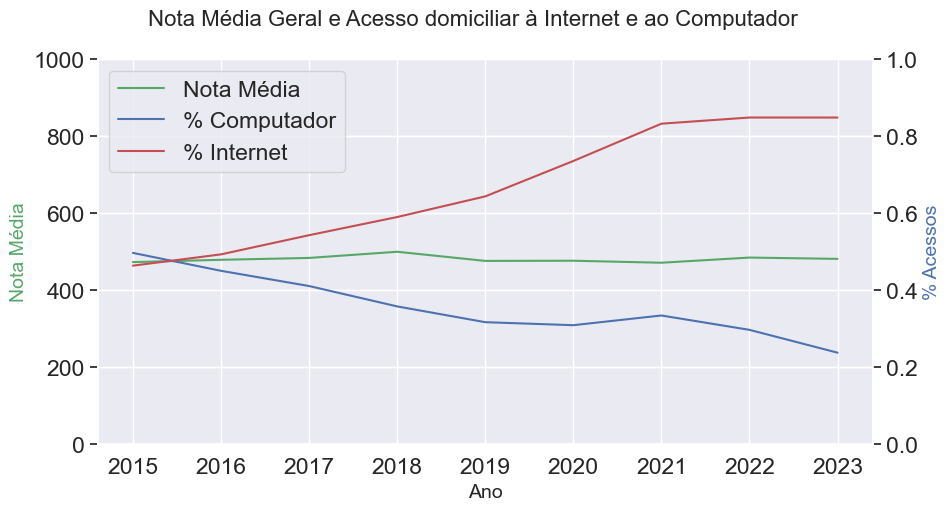

In [231]:
rend(df_models, y1min = 0, y1max = 1000, y2min = 0.0, y2max = 1.0)

# Questão #3

### A importância da variável "acesso a internet", para predizer a performance geral do aluno, aumentou ao longo dos anos, dentre alunos homens?

# Um modelo por ano

## Datasets

In [232]:
### Para cada ano e alunos homens, temos um conjunto de dados:

df_models_ano = {}
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}


for i, ano in enumerate(anos):
    
    # df
    df_models_ano[i] = df_models[df_models['NU_ANO'] == ano][df_models['FEMININO'] == 0]
    
    # Features
    X[i] = df_models[df_models['NU_ANO'] == ano][df_models['FEMININO'] == 0][keep_X_features]
    print('Shape X[',ano,']..:', X[i].shape)
    
    # Target
    y[i] = df_models[df_models['NU_ANO'] == ano][df_models['FEMININO'] == 0][keep_y]

    # Train Test Split
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size = 0.5, random_state = 42)

    print('Qtde treino......:', X_train[i].shape)
    print('Qtde teste.......:', X_test[i].shape)

Shape X[ 2015 ]..: (71379, 30)
Qtde treino......: (35689, 30)
Qtde teste.......: (35690, 30)
Shape X[ 2016 ]..: (82248, 30)
Qtde treino......: (41124, 30)
Qtde teste.......: (41124, 30)
Shape X[ 2017 ]..: (79443, 30)
Qtde treino......: (39721, 30)
Qtde teste.......: (39722, 30)
Shape X[ 2018 ]..: (73354, 30)
Qtde treino......: (36677, 30)
Qtde teste.......: (36677, 30)
Shape X[ 2019 ]..: (70220, 30)
Qtde treino......: (35110, 30)
Qtde teste.......: (35110, 30)
Shape X[ 2020 ]..: (41199, 30)
Qtde treino......: (20599, 30)
Qtde teste.......: (20600, 30)
Shape X[ 2021 ]..: (38535, 30)
Qtde treino......: (19267, 30)
Qtde teste.......: (19268, 30)
Shape X[ 2022 ]..: (48441, 30)
Qtde treino......: (24220, 30)
Qtde teste.......: (24221, 30)
Shape X[ 2023 ]..: (56184, 30)
Qtde treino......: (28092, 30)
Qtde teste.......: (28092, 30)


## XGBoost Models

In [233]:
# XGBoosting
model_xg = {}
auc_xg_train = {}
fpr_xg_train = {}
tpr_xg_train = {}
thresholds_xg_train = {}

auc_xg_test = {}
fpr_xg_test = {}
tpr_xg_test = {}
thresholds_xg_test = {}

columns = ['model','ano','feature','score']
rows_anos = []

for i, ano in enumerate(anos):
    
    print('Ano', ano, ':')
    # Fit model
    print('    Fit...')
    model_xg[i] = XGBClassifier().fit(X_train[i], y_train[i].target_geral, eval_metric = 'logloss')
    
    # Apply model
    print('    Apply...')
    df_models_ano[i]['xg_pred'] = model_xg[i].predict_proba(df_models_ano[i][keep_X_features])[:, 1]
    
    # Compare
    print('    Compare...')
    y_train[i]['xg_pred'] = model_xg[i].predict_proba(X_train[i])[:, 1]
    y_test[i]['xg_pred'] = model_xg[i].predict_proba(X_test[i])[:, 1]
        
    # AUC pro treino e teste
    print('    AUCs:')
    # treino
    auc_xg_train[i] = roc_auc_score(y_train[i].target_geral, y_train[i].xg_pred)
    fpr_xg_train[i], tpr_xg_train[i], thresholds_xg_train[i] = roc_curve(y_train[i].target_geral, y_train[i].xg_pred)
    print('        Treino:', auc_xg_train[i])
    
    # teste
    auc_xg_test[i] = roc_auc_score(y_test[i].target_geral, y_test[i].xg_pred)
    fpr_xg_test[i], tpr_xg_test[i], thresholds_xg_test[i] = roc_curve(y_test[i].target_geral, y_test[i].xg_pred)
    print('        Teste:', auc_xg_test[i])
    
    # Feature importance
    print('    Feature importance...')
    importance = model_xg[i].feature_importances_
    for j, v in enumerate(importance):
        row = ['xg', ano, keep_X_features[j], v]
        rows_anos.append(row)

Ano 2015 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.731854905373656
        Teste: 0.6371880183241343
    Feature importance...
Ano 2016 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7326200413001105
        Teste: 0.6398714389159669
    Feature importance...
Ano 2017 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.729699243957942
        Teste: 0.6441601252757697
    Feature importance...
Ano 2018 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7400182126292774
        Teste: 0.6453839811419647
    Feature importance...
Ano 2019 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.7342862060515761
        Teste: 0.645881907925995
    Feature importance...
Ano 2020 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino: 0.761641845842254
        Teste: 0.6455934862539513
    Feature importance...
Ano 2021 :
    Fit...
    Apply...
    Compare...
    AUCs:
        Treino

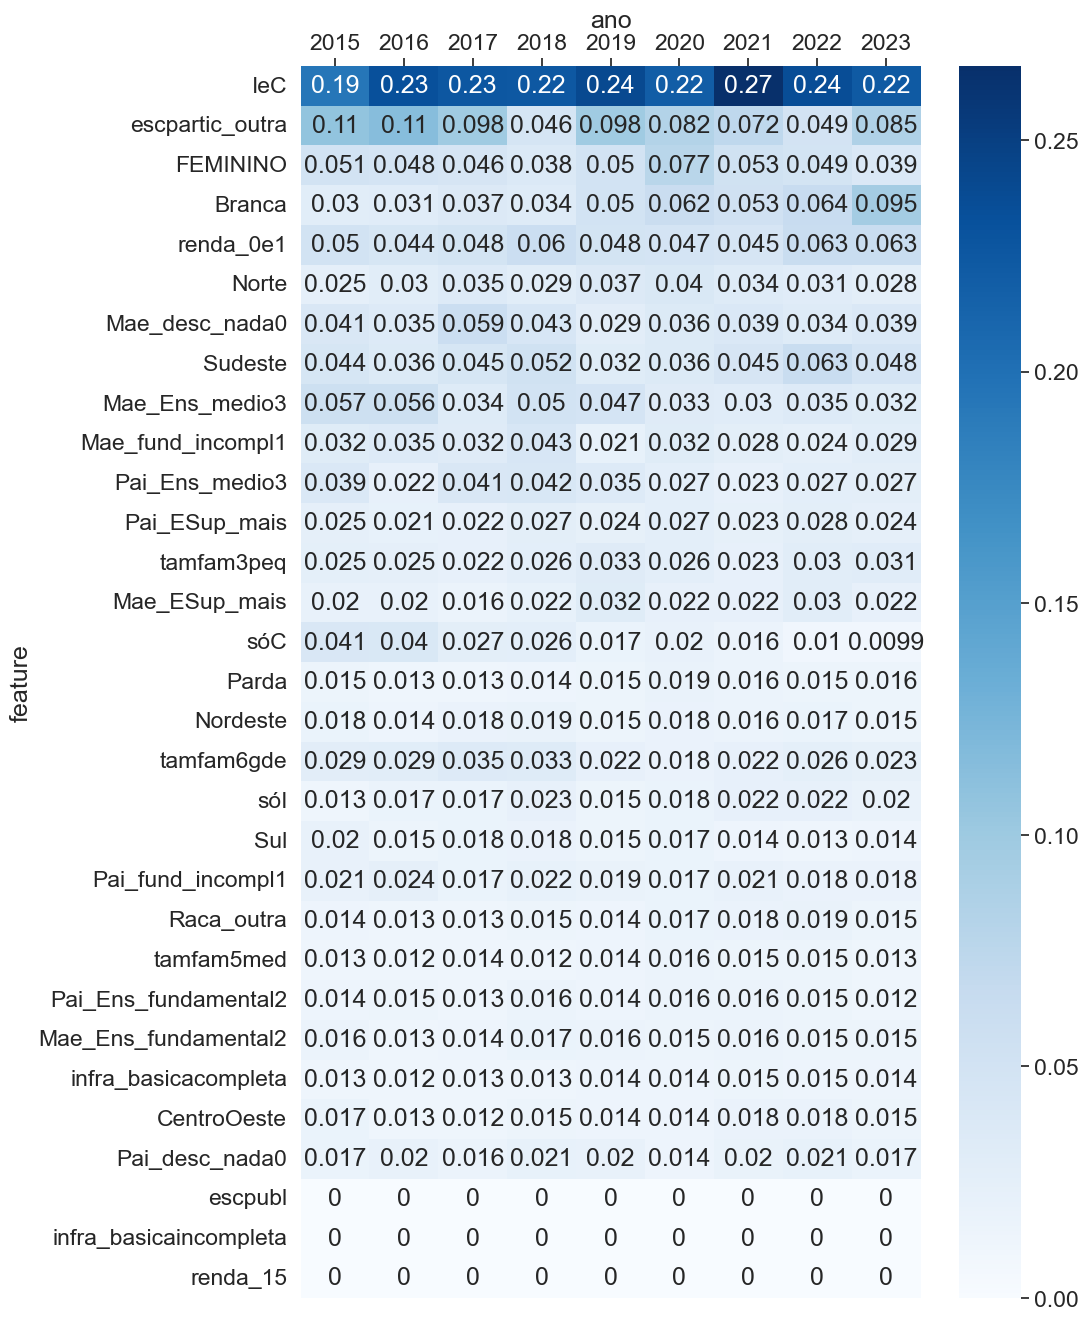

In [314]:
df_feat_impor_anos_homens = pd.DataFrame(rows_anos, columns=columns)

# importância ordenada pelo melhor modelo na validação (xg)
imp_anos = df_feat_impor_anos_homens.pivot(index = 'feature', columns = 'ano', values = 'score').sort_values(by=[2020], ascending = False)

fig, ax = plt.subplots(figsize=(10,16))
sns.heatmap(imp_anos, cmap = 'Blues', annot=True, ax = ax)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.show()

In [316]:
imp_anos.to_excel("general_models_feature_importance_classificacao_final2708anos.xlsx")